In [1]:
import pandas as pd
import numpy as np

#from pgmpy.utils import get_example_model
import matplotlib.pyplot as plt
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination,BeliefPropagation
from pgmpy.estimators import BayesianEstimator,MaximumLikelihoodEstimator,PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore
from pgmpy.estimators import ExpectationMaximization as EM
from pgmpy.readwrite import XMLBIFWriter,XMLBIFReader

import scipy.stats as ss
#from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler

from collections import Counter
#from imblearn.over_sampling import RandomOverSampler

import networkx as nx
#import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,FunctionTransformer,KBinsDiscretizer,LabelBinarizer
import sklearn
print(sklearn.__version__)

1.3.0


In [2]:
full_data=pd.read_csv("/Users/joaoalmeida/Desktop/test.csv",index_col=[0])

In [3]:
len(full_data.columns)

24

In [4]:
ord_cols=["BISHOP_SCORE",
"BISHOP_CONSISTENCIA",
"BISHOP_DESCIDA",
"BISHOP_DILATACAO",
"BISHOP_EXTINCAO",
"BISHOP_POSICAO"]

int_cols = ["A_PARA","A_GESTA","EUTOCITO_ANTERIOR","FORCEPS_ANTERIOR","CESARIANAS_ANTERIOR",
    "IDADE_MATERNA",
    "PESO_INICIAL",
    "IMC",
    "NUMERO_CONSULTAS_PRE_NATAL",
    "IDADE_GESTACIONAL_ADMISSAO",
    "SEMANAS_GESTACAO_PARTO",
    "PESO_ADMISSAO_INTERNAMENTO",
    "ESTIMATIVA_PESO_ECO_30",
    "ESTIMATIVA_PESO_ECO_31",
    "ESTIMATIVA_PESO_ECO_32",
    "ESTIMATIVA_PESO_ECO_24",
    "VENTOSAS_ANTERIOR",
"ESTIMATIVA_PESO_ECO_25",
"ESTIMATIVA_PESO_ECO_26",
"ESTIMATIVA_PESO_ECO_27",
"ESTIMATIVA_PESO_ECO_28",
"ESTIMATIVA_PESO_ECO_29",
"ESTIMATIVA_PESO_ECO_33",
"ESTIMATIVA_PESO_ECO_34",
"ESTIMATIVA_PESO_ECO_35",
"ESTIMATIVA_PESO_ECO_36",
"ESTIMATIVA_PESO_ECO_37",
"ESTIMATIVA_PESO_ECO_38",
"ESTIMATIVA_PESO_ECO_39",
"ESTIMATIVA_PESO_ECO_40",
"ESTIMATIVA_PESO_ECO_41"]
cat_cols = list(set(full_data.columns)  - set(int_cols) -set(ord_cols))

In [5]:
ord_cols=[col for col in ord_cols if col  in full_data.columns ]
int_cols=[col for col in int_cols if col  in full_data.columns ]


In [6]:
full_data[cat_cols]=full_data[cat_cols].astype(str)

In [7]:
#list(full_data["G_TERAPEUTICA"].unique())
#transform all from SIM/NAO to S/N e similar
#BACIA [nan 'ADEQUADA' 'LIMITE' 'INADEQUADA' 'A' 'L']
standard_map={-1:np.nan,-7:np.nan,"ADEQUADA":"A","LIMITE":"L","DESCONHECIDO,RH_DESCONHECIDO":np.nan,"DESCONHECIDO,":np.nan,"SIM":"S","NAO":"N","-1":np.nan,-1:np.nan,"NS":np.nan,",":np.nan,"Sim":"S","UNKNOWN":np.nan,"Desconhecida":np.nan,"Desconhecido":np.nan,"DESCONHECIDO":np.nan," ":np.nan,"Desconhecido,":np.nan,"  ":np.nan}
def standardize_null(x,mapping):
    if x in mapping.keys():
        return mapping[x]
    if pd.isna(x):
        return np.nan
    return x

for col in full_data.columns:
    full_data[col]=full_data[col].apply(standardize_null,mapping=standard_map)

In [8]:
full_data["SEMANAS_GESTACAO_PARTO"].value_counts()

SEMANAS_GESTACAO_PARTO
39.0    5550
40.0    5001
41.0    3826
39.1    3733
39.2    3303
        ... 
22.1       1
48.6       1
23.6       1
0.0        1
42.3       1
Name: count, Length: 152, dtype: int64

In [9]:
bin_list=[2,3,2,2,5,5,5,4,5,5,2]

In [10]:
numeric_transformer = Pipeline(
     steps=[#("dummy",'passthrough')
         (
            "imputer",
            SimpleImputer(
                missing_values=np.nan, strategy="median"
            )
        ),("kbins",KBinsDiscretizer(n_bins=bin_list, encode='ordinal', strategy='quantile'))
    ]
)
ordinal_transformer= Pipeline(
    steps=[#("dummy",'passthrough')
         (
            "imputer",
            SimpleImputer(
                missing_values=np.nan, strategy="median"
            )
        )#,
    ]
)

categorical_transformer = Pipeline(
    steps=[ #("fun_str", fun_str),
       
        (
            "imputer",
            SimpleImputer(
                missing_values=np.nan, strategy="constant", fill_value="Unknown"
            )
        ),

                ("ordinalEncoder", OrdinalEncoder())

    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, int_cols),
        ("ord",ordinal_transformer,ord_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
bn_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

In [11]:
X_treated_bn=bn_pipeline.fit_transform(full_data)

/opt/homebrew/Caskroom/miniforge/base/envs/dq/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 10 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [12]:
X_treated_df=pd.DataFrame(X_treated_bn,columns=bn_pipeline.get_feature_names_out())
X_treated_df.columns=[l.replace("num__","").replace("cat__","") for l in X_treated_df.columns]


In [13]:
kbins = bn_pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['kbins']

In [14]:
bin_edges = kbins.bin_edges_


In [15]:
for i, edges in enumerate(bin_edges):
    print(f"{int_cols[i]}: {edges}")

A_PARA: [ 0.  1. 15.]
A_GESTA: [ 0.  1.  2. 41.]
EUTOCITO_ANTERIOR: [ 0.  1. 15.]
CESARIANAS_ANTERIOR: [0. 1. 4.]
IDADE_MATERNA: [13. 26. 30. 33. 36. 52.]
PESO_INICIAL: [  0.  56.  62.  64.  74. 171.]
IMC: [  0.   21.3  23.5  24.2  27.6 463.7]
NUMERO_CONSULTAS_PRE_NATAL: [ 0.  5.  8. 10. 87.]
IDADE_GESTACIONAL_ADMISSAO: [18.  38.  39.  39.4 40.2 49. ]
SEMANAS_GESTACAO_PARTO: [ 0.  38.1 39.  39.5 40.2 58. ]
VENTOSAS_ANTERIOR: [0. 3.]


In [16]:
X_treated_df["NUMERO_CONSULTAS_PRE_NATAL"].value_counts()

NUMERO_CONSULTAS_PRE_NATAL
2.0    23532
3.0    21415
0.0    15200
1.0    13205
Name: count, dtype: int64

In [17]:
full_data["NUMERO_CONSULTAS_PRE_NATAL"].value_counts()

NUMERO_CONSULTAS_PRE_NATAL
8.0     6229
9.0     5339
2.0     5230
7.0     5190
10.0    5093
6.0     4789
4.0     3823
1.0     3554
11.0    3513
5.0     3226
12.0    2991
3.0     2570
13.0    2067
14.0    1820
15.0    1374
16.0    1174
17.0     850
18.0     665
19.0     458
20.0     411
21.0     268
22.0     201
23.0     122
24.0      98
26.0      61
25.0      57
27.0      39
29.0      25
28.0      24
30.0      23
0.0       23
31.0      16
33.0      15
35.0      12
32.0      10
34.0       7
37.0       6
36.0       4
41.0       3
38.0       3
40.0       2
39.0       1
56.0       1
87.0       1
Name: count, dtype: int64

In [18]:
import joblib
joblib.dump(bn_pipeline, '../pipeline.sav')

['pipeline.sav']

## Create final with all data

In [19]:
var_mapping={'IDADE_MATERNA': 'IA',
 'GS': 'GS',
 'PESO_INICIAL': 'PI',
 'PESO_ADMISSAO_INTERNAMENTO': 'PAI',
 'IMC': 'IMC',
 'CIGARROS': 'CIG',
 'ALCOOL': 'ALC',
 'ESTUPEFACIENTES': 'ESTP',
 'A_PARA': 'APARA',
 'A_GESTA': 'AGESTA',
 'EUTOCITO_ANTERIOR': 'EA',
 'VENTOSAS_ANTERIOR': 'VA',
 'FORCEPS_ANTERIOR': 'FA',
 'CESARIANAS_ANTERIOR': 'CA',
 'TIPO_GRAVIDEZ': 'TG',
 'VIGIADA': 'V',
 'NUMERO_CONSULTAS_PRE_NATAL': 'NRCPN',
 'VIGIADA_PARICULAR': 'VP',
 'VIGIADA_CENTRO_SAUDE': 'VCS',
 'VIGIADA_NESTE_HOSPITAL': 'VNH',
 'E_ALT_UT': 'EALTUT',
 'BACIA': 'B',
 'APRESENTACAO_ADMISSAO': 'AA',
 'BISHOP_SCORE': 'BS',
 'BISHOP_CONSISTENCIA': 'BC',
 'BISHOP_DESCIDA': 'BDE',
 'BISHOP_DILATACAO': 'BDI',
 'BISHOP_EXTINCAO': 'BE',
 'BISHOP_POSICAO': 'BP',
 'IDADE_GESTACIONAL_ADMISSAO': 'IGA',
 'TRAB_PARTO_ENTRADA_ESPONTANEO': 'TPEE',
 'TRAB_PARTO_ENTRADA_INDUZIDO': 'TPEI',
 'RPM': 'RPM',
 'HIPERTENSAO_CRONICA': 'HC',
 'HIPERTENSAO_GESTACIONAL': 'HG',
 'HIPERTENSAO_PRE_ECLAMPSIA': 'HPE',
 'DIABETES_GESTACIONAL': 'DG',
 'DIABETES_GESTACIONAL_DIETA': 'DGD',
 'DIABETES_GESTACIONAL_INSULINA': 'DGI',
 'DIABETES_GESTACIONAL_ANTIBIO': 'DGA',
 'DIABETES_MATERNA': 'DM',
 'DIABETES_TIPO1': 'DT1',
 'DIABETES_TIPO2': 'DT2',
 'HEMATOLOGICA': 'H',
 'RESPIRATORIA': 'R',
 'CEREBRAL': 'CE',
 'CARDIACA': 'CARD',
 'TIPO_PARTO': 'TP',
 'APRESENTACAO_NO_PARTO': 'ANP',
 'TRAB_PARTO_NO_PARTO': 'TPNP',
 'SEMANAS_GESTACAO_PARTO': 'SGP',
 'GRUPO_ROBSON': 'GR'}


In [20]:
scoring= K2Score(X_treated_df)
est = HillClimbSearch(X_treated_df)
model = est.estimate(scoring_method=scoring)
# Define a model structure with latent variables
model_final = BayesianNetwork(model)

model_final.fit(X_treated_df, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [21]:
labels={}
for k,v in var_mapping.items():
    if k in model_final.nodes():
        labels[k]=v


In [22]:
labels["silo"]="S"
labels["A_GESTA"]="AG"
labels["A_PARA"]="AP"
labels["NUMERO_CONSULTAS_PRE_NATAL"]="NRC"

In [23]:
del labels["VENTOSAS_ANTERIOR"]

In [24]:
X_treated_df["VENTOSAS_ANTERIOR"].value_counts()

VENTOSAS_ANTERIOR
0.0    73352
Name: count, dtype: int64

In [25]:
full_data["VENTOSAS_ANTERIOR"].value_counts()

VENTOSAS_ANTERIOR
0.0    10064
1.0     5741
2.0      172
3.0        8
Name: count, dtype: int64

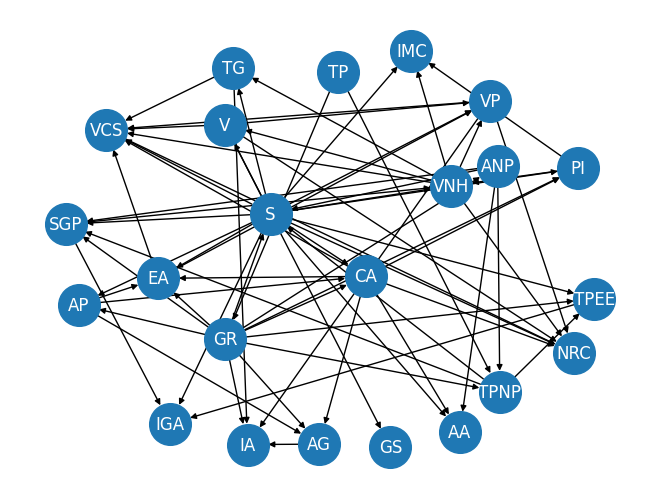

In [26]:

# Create a directed graph from the edges of the Bayesian Network
G = nx.DiGraph()
G.add_edges_from(model_final.edges())

# Draw the graph using networkx
pos = nx.spring_layout(G,k=2)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, arrows=True,node_size=900,labels=labels,arrowsize=8.5,font_color="white")

# Save the figure
plt.savefig('network.png', format='PNG')

# Display the graph
plt.show()

In [27]:
writer = XMLBIFWriter(model_final)
writer.write_xmlbif('../model_total.xml')